# 영화 관객수 예측 경진대회
### 🚣‍♂️목적
주어진 데이터를 바탕으로 영화의 관객수를 예측

### 📔코드북
* title : 영화의 제목
* distributor : 배급사
* genre : 장르
* release_time : 개봉일
* time : 상영시간(분)
* screening_rat : 상영등급
* director : 감독이름
* dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
* dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
* num_staff : 스텝수
* num_actor : 주연배우수
* box_off_num : 관객수

[출처] <a href="https://dacon.io/competitions/open/235536/overview/description"> 영화 관객수 예측 경진대회 </a>

## 필요한 패키지와 데이터셋 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('movies_train.csv')
test = pd.read_csv('movies_test.csv')
submission = pd.read_csv('submission.csv')

## 데이터탐색

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [4]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [5]:
test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


In [6]:
submission.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [7]:
# 수치형변수 기술통계
pd.options.display.float_format = '{:.1f}'.format
train.describe().T

,count,mean,std,min,25%,50%,75%,max
time,600.0,100.9,18.1,45.0,89.0,100.0,114.0,180.0
dir_prev_bfnum,270.0,1050442.9,1791408.3,1.0,20380.0,478423.6,1286568.6,17615314.0
dir_prev_num,600.0,0.9,1.2,0.0,0.0,0.0,2.0,5.0
num_staff,600.0,151.1,165.7,0.0,17.0,82.5,264.0,869.0
num_actor,600.0,3.7,2.4,0.0,2.0,3.0,4.0,25.0
box_off_num,600.0,708181.8,1828005.9,1.0,1297.2,12591.0,479886.8,14262766.0


In [8]:
# 장르별 관객수
no_g = train[["genre", "box_off_num"]].groupby("genre").mean().sort_values("box_off_num")
no_g

,box_off_num
genre,
뮤지컬,6627.0
다큐멘터리,67172.3
서스펜스,82611.0
애니메이션,181926.7
멜로/로맨스,425968.0
미스터리,527548.2
공포,590832.5
드라마,625689.8
코미디,1193914.0


### EDA

In [9]:
# 상관계수
corr = train.corr()

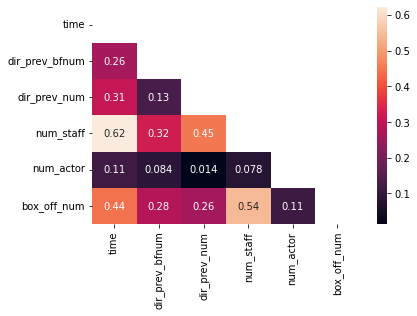

In [10]:
mask = np.triu(np.ones_like(corr))

plt.figure(figsize=(6, 4))
sns.heatmap(data=corr, annot=True, mask=mask);

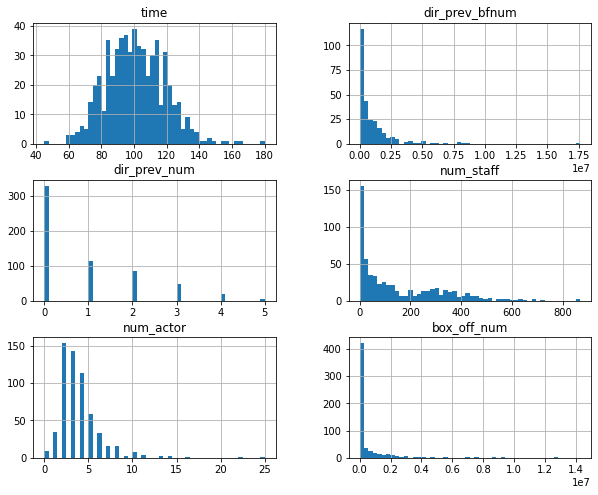

In [11]:
# 히스토그램
_ = train.hist(bins=50, figsize=(10, 8))

## 데이터 전처리

### 배급사 전처리

In [12]:
train['distributor'] = train.distributor.str.replace("(주)", '')
test['distributor'] = test.distributor.str.replace("(주)", '')

In [13]:
train.loc[:, 'distributor']

0         롯데엔터테인먼트
1            ()쇼박스
2            ()쇼박스
3            ()NEW
4      쇼박스()미디어플렉스
          ...     
595          ()NEW
596          ()쇼박스
597       ()마운틴픽쳐스
598      CJ 엔터테인먼트
599      CJ 엔터테인먼트
Name: distributor, Length: 600, dtype: object

In [14]:
train['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

In [15]:
def get_dis(x) :
    if 'CJ' in x or 'CGV' in x :
        return 'CJ'
    elif '쇼박스' in x :
        return '쇼박스'
    elif 'SK' in x :
        return 'SK'
    elif '리틀빅픽' in x :
        return '리틀빅픽처스'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x :
        return '싸이더스'
    elif '에이원' in x :
        return '에이원'
    elif '마인스' in x :
        return '마인스'
    elif '마운틴픽' in x :
        return '마운틴픽처스'
    elif '디씨드' in x :
        return '디씨드'
    elif '드림팩트' in x :
        return '드림팩트'
    elif '메가박스' in x :
        return '메가박스'
    elif '마운틴' in x :
        return '마운틴'
    else :
        return x

In [16]:
train['distributor'] = train.distributor.apply(get_dis)
test['distributor'] = test.distributor.apply(get_dis)

### 결측치

In [17]:
train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [18]:
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

In [19]:
# 결측치가 많은 데이터 제거
train = train.drop(['dir_prev_bfnum'],axis = 1)
test =  test.drop(['dir_prev_bfnum'],axis = 1)

### 유일값

In [20]:
train.nunique()

title            600
distributor      147
genre             12
release_time     330
time              86
screening_rat      4
director         472
dir_prev_num       6
num_staff        296
num_actor         17
box_off_num      586
dtype: int64

In [21]:
test.nunique()

title            243
distributor       83
genre             12
release_time     182
time              70
screening_rat      4
director         220
dir_prev_num       7
num_staff        165
num_actor         14
dtype: int64

In [22]:
# 감독명 : 너무 다양해서 제거
train = train.drop(['director'],axis = 1)
test = test.drop(['director'],axis = 1)

In [23]:
# 제목 : 의미가 없기 때문에 제거
train = train.drop(['title'],axis= 1)
test = test.drop(['title'],axis= 1)

In [24]:
train.distributor.value_counts()

CJ          68
롯데엔터테인먼트    52
NEW         38
마운틴픽처스      33
쇼박스         28
            ..
OAL올         1
위더스필름        1
콘텐츠윙         1
팝파트너스        1
퍼스트런         1
Name: distributor, Length: 147, dtype: int64

In [25]:
# 상위 5개의 배급사를 제외하고 '기타'로처리
distributor_list = train.distributor.value_counts()[:5]
def func(distributor):
    if distributor in distributor_list:
        return distributor
    else:
        return '기타'

train['distributor'] = train['distributor'].apply(lambda x : func(x))
test['distributor'] = test['distributor'].apply(lambda x : func(x))


In [26]:
# 개봉일을 바탕으로 년,월 변수 생성
train['년'] = train['release_time'].apply(lambda x: int(x[:4]))
train['월'] = train['release_time'].apply(lambda x: int(x[5:7]))
train =  train.drop(['release_time'],axis = 1)

test['년'] = test['release_time'].apply(lambda x: int(x[:4]))
test['월'] = test['release_time'].apply(lambda x: int(x[5:7]))
test =  test.drop(['release_time'],axis = 1)


In [27]:
train

,distributor,genre,time,screening_rat,dir_prev_num,num_staff,num_actor,box_off_num,년,월
0,롯데엔터테인먼트,액션,96,청소년 관람불가,0,91,2,23398,2012,11
1,쇼박스,느와르,130,청소년 관람불가,2,387,3,7072501,2015,11
2,쇼박스,액션,123,15세 관람가,4,343,4,6959083,2013,6
3,NEW,코미디,101,전체 관람가,2,20,6,217866,2012,7
4,쇼박스,코미디,108,15세 관람가,1,251,2,483387,2010,11
...,...,...,...,...,...,...,...,...,...,...
595,NEW,드라마,111,청소년 관람불가,1,510,7,1475091,2014,8
596,쇼박스,드라마,127,15세 관람가,1,286,6,1716438,2013,3
597,마운틴픽처스,공포,99,청소년 관람불가,0,123,4,2475,2010,9
598,CJ,느와르,102,15세 관람가,0,431,4,2192525,2015,5


In [28]:
X = train.drop(['box_off_num'], axis=1)
y = np.log1p(train['box_off_num'])

In [29]:
# 원핫 인코딩
X = pd.get_dummies(X)

In [30]:
X['num_actor'] = np.log1p(X['num_actor'])

In [31]:
test

,distributor,genre,time,screening_rat,dir_prev_num,num_staff,num_actor,년,월
0,기타,느와르,125,청소년 관람불가,2,304,3,2010,1
1,쇼박스,멜로/로맨스,113,12세 관람가,4,275,3,2010,1
2,CJ,드라마,115,12세 관람가,3,419,7,2010,1
3,쇼박스,액션,116,15세 관람가,2,408,2,2010,2
4,CJ,공포,110,15세 관람가,1,380,1,2010,2
...,...,...,...,...,...,...,...,...,...
238,기타,드라마,78,15세 관람가,1,4,4,2015,11
239,기타,다큐멘터리,86,12세 관람가,0,18,2,2015,10
240,기타,느와르,107,청소년 관람불가,0,224,4,2015,10
241,마운틴픽처스,드라마,102,청소년 관람불가,1,68,7,2015,10


In [32]:
# 원핫 인코딩
target = pd.get_dummies(test)

In [33]:
target['num_actor'] = np.log1p(target['num_actor'])

In [34]:
X.shape

(600, 28)

In [35]:
y.shape

(600,)

In [36]:
target.shape

(243, 28)

In [37]:
X.columns

Index(['time', 'dir_prev_num', 'num_staff', 'num_actor', '년', '월',
       'distributor_CJ', 'distributor_NEW', 'distributor_기타',
       'distributor_롯데엔터테인먼트', 'distributor_마운틴픽처스', 'distributor_쇼박스',
       'genre_SF', 'genre_공포', 'genre_느와르', 'genre_다큐멘터리', 'genre_드라마',
       'genre_멜로/로맨스', 'genre_뮤지컬', 'genre_미스터리', 'genre_서스펜스', 'genre_애니메이션',
       'genre_액션', 'genre_코미디', 'screening_rat_12세 관람가',
       'screening_rat_15세 관람가', 'screening_rat_전체 관람가',
       'screening_rat_청소년 관람불가'],
      dtype='object')

In [38]:
target.columns

Index(['time', 'dir_prev_num', 'num_staff', 'num_actor', '년', '월',
       'distributor_CJ', 'distributor_NEW', 'distributor_기타',
       'distributor_롯데엔터테인먼트', 'distributor_마운틴픽처스', 'distributor_쇼박스',
       'genre_SF', 'genre_공포', 'genre_느와르', 'genre_다큐멘터리', 'genre_드라마',
       'genre_멜로/로맨스', 'genre_뮤지컬', 'genre_미스터리', 'genre_서스펜스', 'genre_애니메이션',
       'genre_액션', 'genre_코미디', 'screening_rat_12세 관람가',
       'screening_rat_15세 관람가', 'screening_rat_전체 관람가',
       'screening_rat_청소년 관람불가'],
      dtype='object')

## 모델정의 및 학습

In [39]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [40]:
# 10Fold로 교차검증
kf = KFold(n_splits =  10, shuffle = True, random_state = 42)

In [41]:
# GradientBoostingRegressor
gbm = GradientBoostingRegressor(random_state = 42)

In [42]:
rmse_list = []
gb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    gbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in gbm.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in gbm.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    gb_pred += (sub_pred / 10)

In [43]:
np.mean(rmse_list)

1029400.6343405268

In [44]:
# LGBMRegressor
lgbm = LGBMRegressor(random_state = 518)

In [45]:
rmse_list = []
lgb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    lgbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    lgb_pred += (sub_pred / 10)

In [46]:
np.mean(rmse_list)

1134673.746587212

In [47]:
# XGBRegressor
xgb = XGBRegressor(random_state = 518)

In [48]:
rmse_list = []
xgb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    xgb.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in xgb.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in xgb.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    xgb_pred += (sub_pred / 10)

In [49]:
np.mean(rmse_list)

1147622.246103466

In [50]:
# CatBoostRegressor
cat = CatBoostRegressor(random_state = 518, silent = True)

In [51]:
rmse_list = []
cat_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    cat.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in cat.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in cat.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    cat_pred += (sub_pred / 10)

In [52]:
np.mean(rmse_list)

1155440.1251812156

## 제출파일 생성

In [53]:
submission = pd.read_csv('submission.csv')
submission

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0
...,...,...
238,해에게서 소년에게,0
239,울보 권투부,0
240,어떤살인,0
241,말하지 못한 비밀,0


In [56]:
submission['box_off_num'] = cat_pred

In [57]:
submission

,title,box_off_num
0,용서는 없다,375896.9
1,아빠가 여자를 좋아해,937359.1
2,하모니,327421.1
3,의형제,1392530.1
4,평행 이론,1479190.9
...,...,...
238,해에게서 소년에게,440.6
239,울보 권투부,2214.6
240,어떤살인,75881.1
241,말하지 못한 비밀,2330.7


In [59]:
submission.to_csv(f'{np.mean(rmse_list)}.csv',index = False)